# Классификация текста
## Загрузка сообщений

Для удобства обработки заведем класс `Post`, отражающий все характеристики обрабатываемых сообщений и способный конвертироваться в `pd.Series`.

In [2]:
from enum import IntEnum
import numpy  as np
import pandas as pd

# post type: normal message or spam
class PostType(IntEnum):
    LEGIT = 1,
    SPAM = 2,

# post object
class Post:
    def __init__(self, post_id, post_type: PostType, subject = [], body = []):
        self.post_id = post_id
        self.post_type = post_type
        # filter NaN values
        self.subject = subject[~np.isnan(subject)]
        self.body = body[~np.isnan(body)]

    def __str__(self):
        return f"{{{self.post_type} {{Subject: {self.subject}}} {{Body: {self.body}}}}}"

    # make Post series (subject and body are arrays)
    def to_series(self):
        return pd.Series(data={"id": self.post_id, "type": self.post_type, "subject": self.subject, "body": self.body})

# parse string that contains integer
def parse_int(string):
    try:
        return float(string)
    except:
        return np.nan

# collect word pair
def add_pair(s, w1, w2):
    if (w1, w2) in s or (w2, w1) in s:
        return s
    s.add((w1, w2))
    return s

Загрузим все сообщения из директории и обработаем их содержимое.

In [3]:
from functools import reduce
import os
import re

# load all messages filenames
root = "data/raw/messages/"
filenames = [x[2] for x in os.walk(root)][0]

# parse messages
posts = []
words = set()
words_pairs = set()
empty_subjects = 0

for fn in filenames:
    # parse post id
    post_id = np.array(list(map(parse_int, re.split(r"(\d+)", fn))))[[1, 3]]
    # parse message type
    post_type = PostType.LEGIT if "legit" in fn else PostType.SPAM

    # parse subject and body
    f = open(root + fn, "r")
    subject = f.readline().split(" ")[1:]
    subject = list(map(parse_int, subject))
    body = f.read().split(" ")
    body = list(map(parse_int, body))
    # create post object
    posts.append(Post(post_id, post_type, np.array(subject), np.array(body)))
    empty_subjects += (len(posts[-1].subject) == 0)

    # update words set
    words.update(body)
    words.update(subject)
    words_pairs = add_pair(words_pairs, post_id[0], post_id[1])
    for i in np.arange(1, len(body) - 1):
        words_pairs = add_pair(words_pairs, body[i - 1], body[i])
    for i in np.arange(1, len(subject) - 1):
        words_pairs = add_pair(words_pairs, subject[i - 1], subject[i])

# make dataframe
df = pd.DataFrame(list(map(Post.to_series, posts)))
df.head(5)

,id,type,subject,body
0,"[4421.0, 3.0]",1,"[167.0, 190.0, 82.0, 22006.0, 171.0, 86.0, 167...","[19054.0, 7634.0, 1847.0, 21715.0, 2130.0, 149..."
1,"[932.0, 103.0]",2,"[19054.0, 1847.0, 15527.0, 1613.0, 20382.0, 84...","[1692.0, 14342.0, 21366.0, 2130.0, 12424.0, 16..."
2,"[7591.0, 99.0]",2,[],"[19054.0, 22213.0, 14142.0, 13383.0, 1967.0, 1..."
3,"[10754.0, 54.0]",1,"[14988.0, 118.0, 6661.0, 14372.0, 1835.0, 9110...","[6661.0, 14372.0, 1835.0, 9110.0, 18359.0, 161..."
4,"[6709.0, 45.0]",1,"[5159.0, 2943.0, 9494.0, 1212.0, 84.0, 84.0, 8...","[13872.0, 17345.0, 9131.0, 18957.0, 16502.0, 1..."


In [4]:
print(f"Загружено {len(df)} постов:")
print(f" * {len(df.loc[df.type == 2])} - спам, {len(df.loc[df.type == 1])} - не спам")
print(f" * {len(words)} уникальных слов")
print(f" * {len(words_pairs)} уникальных пар")
print(f" * {empty_subjects} постов без темы")

Загружено 1090 постов:
 * 480 - спам, 610 - не спам
 * 24729 уникальных слов
 * 163035 уникальных пар
 * 23 постов без темы


## Векторизация текста
Для полученных сообщений применим два способа векторизации полей `subject` и `body`.
1. Векторизация с учетом следующего слова (попытка учета порядка).

In [5]:
### methods for pairs vectorization
# encode pairs
def encode_pairs(s):
    res, i = {}, 0
    for el in s:
        res[el] = i
        i += 1
    return res

# get index in encoded map
def get_ind(m, p):
    if p in m:
        return m[p]
    return m[(p[1], p[0])]

words_m  = {w:0 for w in words}
ind = encode_pairs(words_pairs)
wordsp_m = {get_ind(ind, wp):0 for wp in words_pairs}

# 1. vectorize with pairs
def factor_pair(l):
    m = wordsp_m.copy()

    for i in np.arange(1, len(l) - 1):
        m[get_ind(ind, (l[i - 1], l[i]))] += 1
    res = []
    for (_, a) in sorted(m.items()):
        res.append(a)        
    return res

df_pairs = df.copy()
subjects = df_pairs.subject
bodies   = df_pairs.body

df_pairs["subject"] = subjects.map(factor_pair).copy()
df_pairs["body"] = bodies.map(factor_pair).copy()
df_pairs.head(5)

,id,type,subject,body
0,"[4421.0, 3.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[932.0, 103.0]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[7591.0, 99.0]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[10754.0, 54.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[6709.0, 45.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


2. Векторизация по кол-ву раз, которое слово встретилось.

In [6]:
# 2. vectorize with count
def factor_count(l):
    m = words_m.copy()
    for el in l:
        m[el] += 1
    res = []
    for (_, a) in sorted(m.items()):
        res.append(a)     
    return res

df_count = df.copy()
subjects = df_count.subject
bodies   = df_count.body

df_count["subject"] = subjects.map(factor_count).copy()
df_count["body"] = bodies.map(factor_count).copy()
df_count.head(5)

,id,type,subject,body
0,"[4421.0, 3.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[932.0, 103.0]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[7591.0, 99.0]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[10754.0, 54.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[6709.0, 45.0]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Представление в виде разреженной матрицы

In [7]:
from scipy.sparse import csr_matrix

subjects_pair = csr_matrix(list(df_pairs["subject"].values))
body_pair = csr_matrix(list(df_pairs["body"].values))

print(f"* Разреженные матрицы по парам:\n" +
      f"Заголовок:  матрица {subjects_pair.get_shape()} ({subjects_pair.count_nonzero()} значений)\n" +
      f"Тело: матрица {body_pair.get_shape()} ({body_pair.count_nonzero()} значений)")

subjects_count = csr_matrix(list(df_count["subject"].values))
body_count = csr_matrix(list(df_count["body"].values))

print(f"* Разреженные матрицы по кол-ву:\n" +
      f"Заголовок:  матрица {subjects_count.get_shape()} ({subjects_count.count_nonzero()} значений)\n" +
      f"Тело: матрица {body_count.get_shape()} ({body_count.count_nonzero()} значений)")

* Разреженные матрицы по парам:
Заголовок:  матрица (1090, 163035) (4962 значений)
Тело: матрица (1090, 163035) (507798 значений)
* Разреженные матрицы по кол-ву:
Заголовок:  матрица (1090, 24729) (6666 значений)
Тело: матрица (1090, 24729) (245077 значений)


## Учет тела и заголовка сообщений

1. С повышенным весом для заголовка

In [8]:
weight_pair = subjects_pair * 7 + body_pair
weight_count = subjects_count * 7 + body_count

2. Раздельно

## Наивный Байесовский классификатор

Построим 6 полученных моделей.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

def learn_on(trainX, trainY, alpha=1.0):
    model = MultinomialNB(alpha=alpha)
    model.fit(trainX, trainY)
    return model

c_trainX, c_testX, c_trainY, c_testY = train_test_split(weight_count, df_count["type"], test_size=0.2, random_state=0)
p_trainX, p_testX, p_trainY, p_testY = train_test_split(weight_pair, df_count["type"], test_size=0.2, random_state=0)

c_sub_trainX, c_sub_testX, c_sub_trainY, c_sub_testY = train_test_split(subjects_count, df_count["type"], test_size=0.2, random_state=0)
c_bod_trainX, c_bod_testX, c_bod_trainY, c_bod_testY = train_test_split(body_count, df_count["type"], test_size=0.2, random_state=0)

p_sub_trainX, p_sub_testX, p_sub_trainY, p_sub_testY = train_test_split(subjects_pair, df_count["type"], test_size=0.2, random_state=0)
p_bod_trainX, p_bod_testX, p_bod_trainY, p_bod_testY = train_test_split(body_pair, df_count["type"], test_size=0.2, random_state=0)

model1 = learn_on(c_trainX, c_trainY)
model2 = learn_on(p_trainX, p_trainY)

model_c_sub = learn_on(c_sub_trainX, c_sub_trainY)
model_c_bod = learn_on(c_bod_trainX, c_bod_trainY)

model_p_sub = learn_on(p_sub_trainX, p_sub_trainY)
model_p_bod = learn_on(p_bod_trainX, p_bod_trainY)

Выберем среди всех моделей наилушую метрикой AUC (площадь под кривой).

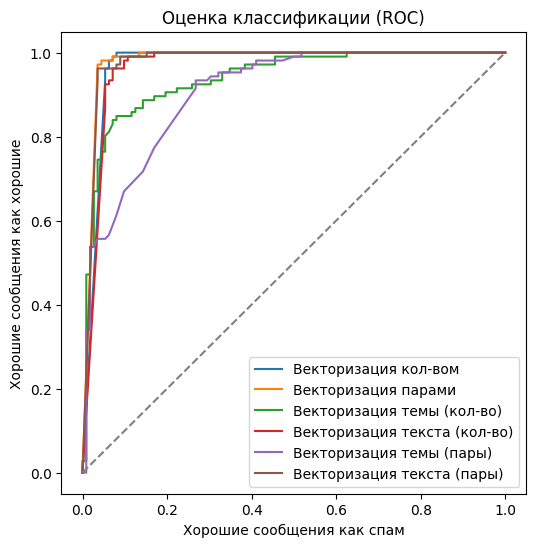

* AUC: [0.97086, 0.98029, 0.93906, 0.96664, 0.9068, 0.97844]


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

prediction1 = model1.predict_proba(c_testX)[:, 1]
prediction2 = model2.predict_proba(p_testX)[:, 1]

prediction_c_sub = model_c_sub.predict_proba(c_sub_testX)[:, 1]
prediction_c_bod = model_c_bod.predict_proba(c_bod_testX)[:, 1]

prediction_p_sub = model_p_sub.predict_proba(p_sub_testX)[:, 1]
prediction_p_bod = model_p_bod.predict_proba(p_bod_testX)[:, 1]

fpr1, tpr1, _ = roc_curve(c_testY, prediction1, pos_label=2)
fpr2, tpr2, _ = roc_curve(p_testY, prediction2, pos_label=2)

fpr_c_sub, tpr_c_sub, _ = roc_curve(c_sub_testY, prediction_c_sub, pos_label=2)
fpr_c_bod, tpr_c_bod, _ = roc_curve(c_bod_testY, prediction_c_bod, pos_label=2)

fpr_p_sub, tpr_p_sub, _ = roc_curve(p_sub_testY, prediction_p_sub, pos_label=2)
fpr_p_bod, tpr_p_bod, _ = roc_curve(p_bod_testY, prediction_p_bod, pos_label=2)

plt.figure(figsize=(6, 6))
plt.title("Оценка классификации (ROC)")
plt.xlabel("Хорошие сообщения как спам")
plt.ylabel("Хорошие сообщения как хорошие")

plt.plot(fpr1, tpr1, label="Векторизация кол-вом")
plt.plot(fpr2, tpr2, label="Векторизация парами")
plt.plot(fpr_c_sub, tpr_c_sub, label="Векторизация темы (кол-во)")
plt.plot(fpr_c_bod, tpr_c_bod, label="Векторизация текста (кол-во)")
plt.plot(fpr_p_sub, tpr_p_sub, label="Векторизация темы (пары)")
plt.plot(fpr_p_bod, tpr_p_bod, label="Векторизация текста (пары)")

plt.plot([0, 1], [0, 1], color="grey", linestyle="dashed")
plt.legend(loc="lower right")
plt.show()

auc_l = [0] * 6
auc_l[0] = round(auc(fpr1, tpr1), 5)
auc_l[1] = round(auc(fpr2, tpr2), 5)

auc_l[2] = round(auc(fpr_c_sub, tpr_c_sub), 5)
auc_l[3] = round(auc(fpr_c_bod, tpr_c_bod), 5)

auc_l[4] = round(auc(fpr_p_sub, tpr_p_sub), 5)
auc_l[5] = round(auc(fpr_p_bod, tpr_p_bod), 5)

print(f"* AUC: {auc_l}")

Наибольший показатель метрики у векторизации парами (сохранение контекста). Также, сравнивая отдельную векторизацию текста и векторизацию, учитывающую оба текстовых поля, можно заметить, что заголовки постов вносят незначительный вклад в предсказание.

## Установка априорного распределения

* Found 1 points
* Best: 0.0 (0.97642 accuracy)


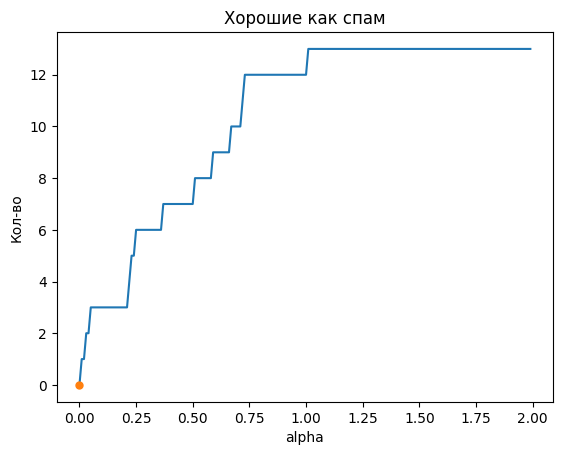

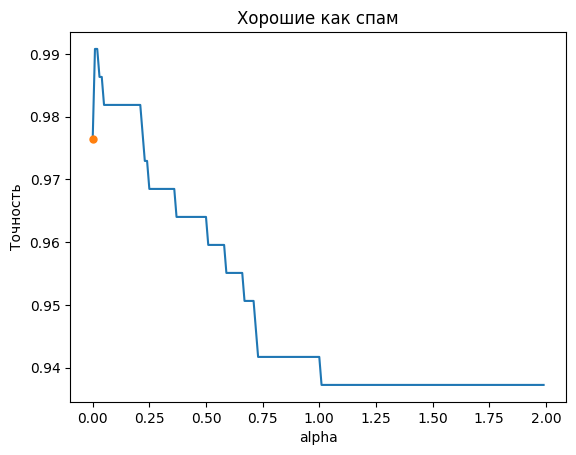

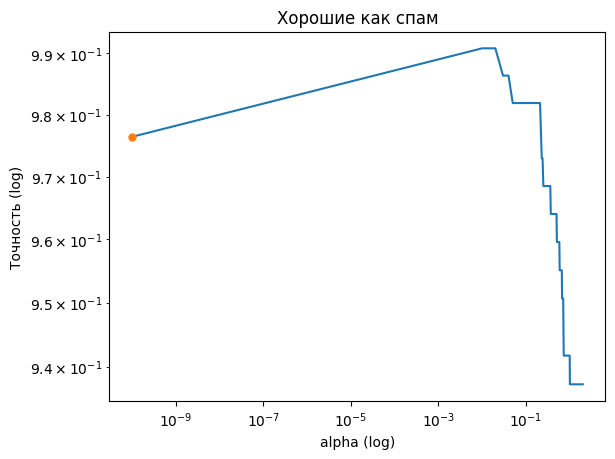

In [14]:
from sklearn.metrics import mean_absolute_percentage_error


ys1 = []
ys2 = []
xs = np.arange(1e-10, 2, 1e-2)

def test_model():
    results = []

    for a in xs:
        model = learn_on(p_trainX, p_trainY, a)
        prediction = model.predict(p_testX)

        # count false-negative
        ys1.append(((np.array(p_testY) == PostType.LEGIT) & (np.array(prediction) == PostType.SPAM)).sum())
        # count accuracy
#        ys2.append((np.array(p_testY) == np.array(prediction)).sum() / len(p_testY))
        fpr, tpr, _ = roc_curve(p_testY, prediction, pos_label=2)
        ys2.append(auc(fpr, tpr))

        if ys1[-1] == 0:
            results.append(a)
    return results

results = test_model()

if not results is None:
    max_acc, max_ind = -1, -1
    for i in np.arange(0, len(ys2)):
        if xs[i] in results and ys2[i] > max_acc:
            max_acc, max_ind = ys2[i], i
    print(f"* Found {len(results)} points\n* Best: {round(xs[max_ind], 5)} ({round(ys2[max_ind], 5)} accuracy)")

plt.title("Хорошие как спам")
plt.ylabel("Кол-во")
plt.xlabel("alpha")
plt.plot(xs, ys1)
plt.plot(xs[max_ind], ys1[max_ind], marker="o", markersize=5)
plt.show()

plt.title("Хорошие как спам")
plt.ylabel("Точность")
plt.xlabel("alpha")
plt.plot(xs, ys2)
plt.plot(xs[max_ind], ys2[max_ind], marker="o", markersize=5)
plt.show()

plt.title("Хорошие как спам")
plt.ylabel("Точность (log)")
plt.xlabel("alpha (log)")
plt.xscale("log")
plt.yscale("log")
plt.plot(xs, ys2)
plt.plot(xs[max_ind], ys2[max_ind], marker="o", markersize=5)
plt.show()